---

# **Sentiment Analysis**

---

# **Categories**

## **1. as text analysis**
- confident --> else: word not confident
- happy/joyful words --> else:  ...
- enthusiasm --> "I enjoy", "I love", "I take pride in"

- slang words

- filler words? : what words

- focus --> concise, answer lenght

## **2. as speech recognition (tone)**
- engaged --> tone, bored, desinerested, certainm ...

- long pause? : output

## **3. once 1 and 2 is finished**
- quantifying  first impressions
- answer pace
- higher level groupings --> confidence + certain = proffesional

---

# **1. Installation**

---

## i. Generating a reponse


In [ ]:
import sys
import logging
from psutil import virtual_memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9

In [ ]:
tf_response = {
    'error': None,
    'TF version': '',
    'COLAB': None,
    'GPU': False,
    'ram_gb': ''
}

In [ ]:
try:
    # drive
    from google.colab import drive
    IN_COLAB = 'google.colab' in sys.modules

    # updating tensorflow version
    %tensorflow_version 2.x

    # tensorflow-gpu
    !pip install tensorflow-gpu # !pip install tensorflow_text # I could use BERT
    
    # NLP (nltk, stanza, spacy)
    !pip install nltk 
    !pip install stanza
    !pip install spacy
    !spacy download en_core_web_sm # sm md lg
    !python -m spacy download en
except OSError as error:
    # debugging error
    response['error'] = logging.debug('You are not using your specify version of TensorFlow')
    IN_COLAB = False

    # install requirements
    !pip install -r '../requirements.txt'
finally:
    tf_response['COLAB'] = IN_COLAB
    
    # Importing tensroflow core
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

    from sklearn.model_selection import train_test_split
    
    # GPU and RAM response
    if tf.config.list_physical_devices('GPU'):
            GPU = True
            tf_response['GPU'] = GPU
        tf_response['TF_version'] = tf.__version__
        
        if tf_response['COLAB'] == True:
            if gpu_info.find('failed') >= 0:
                print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator')
                print('Re-execute this cell.')
            else:
                print(gpu_info)
            
            if ram_gb < 20:
                print('To enable a high-RAM runtime, select the Runtime > "Change runtime type menu"')
                print('Select high-RAM in the runtime shape dropdown')
                print('Re-execute this cell')
                tf_response['ram_gb'] = 'low-RAM runtime'
            else:
                tf_response['ram_gb'] = 'high-RAM runtime'
            print('\nRuntime {:.2f} GB of available RAM\n'.format(ram_gb))


In [ ]:
print(tf_response)

## ii. Importing modules

In [3]:
# Data analysis
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import re

# Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

In [ ]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))

In [ ]:
# Stanza NLP
import stanza

stanza.download('en', package='ewt', processors='tokenize,mwt,pos,lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,mwt,pos,lemma',
                      lang='en',
                      use_gpu=True)

In [ ]:
# testing stanza
doc = stNLP('Barack Obama was born in Hawai.')
print('\n')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

In [ ]:
# Spacy NLP
import spacy
spNLP = spacy.load('en_core_web_sm')
spNLP.max_length = 103950039 # or higher
# spacy.prefer_gpu() #will not work with stanza


---

# **2. Global variables (control)**

---

In [54]:
EPOCHS = 30
vocab_size = 5000
embedding_dim = 64
max_lenght = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

PATH_FILE = 'data/training.1600000.processed.noemoticon.csv'
FILE = 'data/sentiment-subset.csv'
main_labels = ['happy', 'confident', 'sad', 'not confident']

---

# 3. **Lemmatization**

---

In [10]:
# lemmatizion
# stanza
def stanza_lemma(text):
    doc = stNLP(text)
    return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

In [ ]:
def nltk_lemma(text):
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)

---

# **3. Preprocessing & load dataset**

---

### i. Load database

In [9]:
def load_data(data_path=None):
    !mkdir -p data
    !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
    !unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

### ii. Preprocess dataset

In [11]:
def preprocess_dataset():
    # load_data
    load_data()
    print('Database loaded\n')

    # cleaning data
    unclean_df = pd.read_csv(PATH_FILE,
                     names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                     encoding='latin-1') # if utf-8: UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 232719-232720: invalid continuation byte

    unclean_df.polarity = unclean_df.polarity.replace({0: 0, 4: 1}) # replace polarity
    unclean_df = unclean_df.drop(columns=['id', 'date', 'query', 'user']) # dropping unneeded columns

    # sample
    #df_sample = unclean_df.sample(n=500000)
    #df_sample.polarity.value_counts()

    # lower case
    unclean_df['text'] = unclean_df['text'].str.lower()

    # remove character and numbers
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'https://www\.|http:\.|https://|www\.', '', x))
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil|cl)[\S]*\s?', '', x))
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-zÁ-Úá-ú \t])|(\w+:\/\/\S+)|^rt|http.+?%', '', x))
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'\d+', '', x))


    # rewritting the created file without NaN values
    unclean_df.to_csv('data/sentiment140-subset.csv', 
              quotechar='"', # check later!
              encoding='latin-1',
              index=False)

    # clean csv
    df = pd.read_csv('data/sentiment140-subset.csv', encoding='latin-1').dropna()

    # checking if there's any NaN values
    isnull = [i for i in (df['text'].isnull()) if i == True]
    if isnull != []:
        sys.exit(0) # add response object here

    
    # STOPWORDS
    # Getting in a list all the stopwords of the dataframe
    #spacy_stop_words = list(dict.fromkeys([str(i) for i in spNLP(' '.join(j for j in df['text'])) if i.is_stop == True]))
    
    '''
    stop_words = stopwords.words('english')
    stop_words.extend(spacy_stop_words)
    stop_words = set(stop_words)
    
    df['text'] = df['text'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop_words]))
    
    # Lemmatization Stanza vs NLTK
    df['text'] = df['text'].apply(lambda x: stanza_lemma(x))
    df['text'] = df['text'].apply(lambda x: nltk_lemma(x))

    # check new stopwords here!
    df['text'] = df['text'].apply(lambda x: ' '.join(
        [i for i in x.split() if i not in stop_words]
    ))
    '''
    # return df
    x, y = df.text, df.polarity
    return x, y

In [12]:
# test peprocess_dataset
x, y = preprocess_dataset()

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip
Database loaded



0    799982
1    799969
Name: polarity, dtype: int64


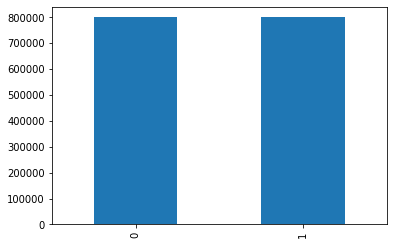

In [13]:
# test peprocess_dataset
print(y.value_counts())
y.value_counts().plot(kind='bar')
plt.show()

In [14]:
# test peprocess_dataset
print(Counter(x).most_common(10))

[(' ', 2301), (' thanks ', 1572), (' get  followers a day using once you add everyone you are on the train or pay vip ', 1324), (' thank you ', 998), (' i am lost please help me find a good home ', 507), (' me too ', 453), ('good morning ', 444), (' good morning ', 355), (' i know ', 342), ('  ', 310)]


### iii. Prepare dataset

In [15]:
def prepare_dataset(test_size=0.2, validation_size=0.2):
    # load dataset
    # split dataset (as string into panda.core.series.Serie object)
    (x, y) = preprocess_dataset()
    
    # create/split train, validation and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)

    # pandas.core.series.Series to numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_validation, y_validation =  np.array(x_validation), np.array(y_validation)
    x_test, y_test = np.array(x_test), np.array(y_test)

    return (x_train, y_train), (x_validation, y_validation), (x_test, y_test)

In [16]:
# test prepare_dataset function
(x_train, y_train), (x_validation, y_validation), (x_test, y_test) = prepare_dataset()

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip
Database loaded



In [1]:
import csv
def prepare_dataset_testing():
    
    # test with csv module
    labels, texts = [], [] 
    with open('data/sentiment140-subset.csv', 'r', encoding='latin-1') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            text = row[1]
            for i in STOPWORDS:
                token = ' ' + i + ' '
                text = text.replace(token, ' ')
                text = text.replace(' ', ' ')
            texts.append(text)

    # split
    train_size = int(len(texts) * training_portion)

    train_texts = texts[:train_size]
    train_labels = labels[:train_size]

    validation_texts = texts[train_size:]
    validation_labels = labels[train_size:]

    # tokenizer
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, 
                          filter='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

    tokenizer.fit_on_texts(train_texts)
    word_index = tokenizer.word_index

    # text to sequences: triain_texts
    train_sequences = tokenizer.texts_to_sequences(train_texts)

    # padding and truncating sequences: train_seq
    train_padded = pad_sequences(sequences=train_sequences, maxlen=max_lenght,
                                 padding=padding_type, truncating=trunc_type)

    # same process: validation_texts
    valdiation_sequences = tokenizer.texts_to_sequences(validation_texts)
    validation_padded = pad_sequences(valdiation_sequences, maxlen=max_lenght, padding=padding_type, truncating=trunc_type)

    # tokenize & sequences to train and validation LABELS
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(labels)

    training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
    validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

    print(label_tokenizer.word_index)

    return train_padded, training_label_seq, validation_padded, validation_label_seq

---
# **4. Build model**
---

In [52]:
def build_model(learning_rate=0.0001, opt='adam', loss='categorical_crossentropy'):
    model = Sequential()

    # layers
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(embedding_dim)))

    # softmax output layer
    model.add(tf.keras.layers.Dense(units=2, # 10 
                                    activation='softmax'))

    # optimizer & loss
    opt = tf.optimizers.Adam(learning_rate=learning_rate)
    loss='sparse_categorical_crossentropy'

    # compile model
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    model.summary()

    return model

---
# **5. Train model** 
---

In [47]:
def train(model, x_train, y_train, x_validation, y_validation,
          epochs, batch_size=32, patience=5, 
          verbose=2, monitor='accuracy'):
    
    # callback
    early_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, # also try 'val_loss'
                                                      verbose=1, mode='auto', restore_best_weights=True,
                                                      min_delta=1e-3, patience=patience)

    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs, verbose=verbose,
                        validation_data=(x_validation, y_validation), # x_test, y_test
                        callbacks=[early_callback])
    return history

---
# **6. Plotting history**
---

In [45]:
def plot_history_(history):
    fitModel_dict = history.history
    acc = fitModel_dict['accuracy']
    val_acc = fitModel_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(15, 8))
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylim((0.5, 1))

    plt.show()

def plot_history(history, string):
    fitModel_dict = history.history
    plt.plot(fitModel_dict[string])
    plt.plot/fitModel_dict['val_' + string]
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

# test
#plot_history(history, 'accuracy')
#plot_history(history, 'loss')

---
# **7. Main**
---

In [55]:
def main():
    # x_train, y_train, x_validation, y_validation, x_test, y_test = prepare_dataset(data_path) # define data path for google colab and visual studio with statements
    train_padded, training_label_seq, validation_padded, validation_label_seq = prepare_dataset_testing()

    # input_shape
    model = build_model()

    history = train(model=model, x_train=train_padded, y_train=training_label_seq,
                    x_validation=validation_padded, y_validation=validation_labels,
                    epochs=EPOCHS, verbose=1)
    plot_history(history)

    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print('\nTest:\nLoss: {}\nAccuracy: {}').format(loss, accuracy * 100)

    model.save(model.h5)

---
# **8. __name__ == "__main__"**
---

In [ ]:
if __name__ == "__main__":
    main()